<a href="https://colab.research.google.com/github/ssarker21/Introduction-to-Machine-Learning/blob/main/Homework2_2(a).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== BASE (no scaling) Model Parameters ===
      bias: 0.214542
      area: 860.229543
  bedrooms: 0.696991
 bathrooms: 0.348578
   stories: 0.507062
   parking: 0.177907

=== STANDARDIZED Model Parameters ===
      bias: 4147996.343276
      area: 651193.854862
  bedrooms: 179189.707177
 bathrooms: 580236.418048
   stories: 414282.260261
   parking: 312016.155773

=== NORMALIZED Model Parameters ===
      bias: 3191574.053835
      area: 968943.232226
  bedrooms: 1344091.733450
 bathrooms: 567512.097525
   stories: 1134687.553298
   parking: 1000760.037225


=== Comparison (MSE lower is better; R² closer to 1 is better) ===
              Setting     LR  Epochs          Train MSE          Val   MSE  Train R²  Val   R²
No Scaling (baseline) 0.0000    1000 3380304856742.2729 3215772214923.9893    0.0283    0.0889
Standardized (inputs) 0.0010    1000 1956931843739.4690 1901488414228.3816    0.4374    0.4613
  Normalized (inputs) 0.0010    1000 2353575181830.2871 2102677794227.4939    0.3

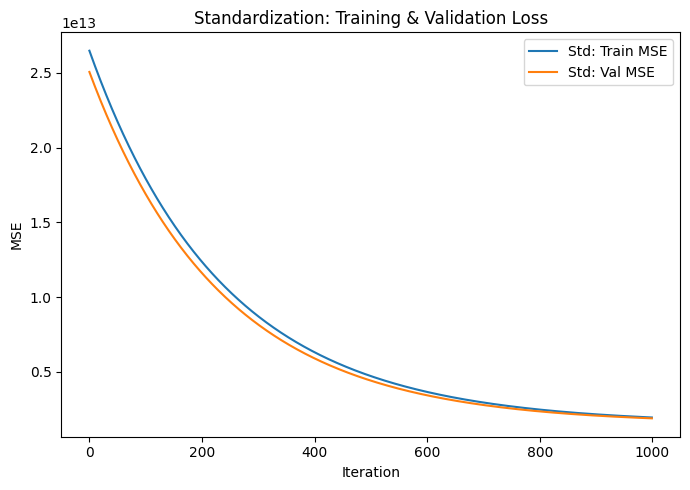

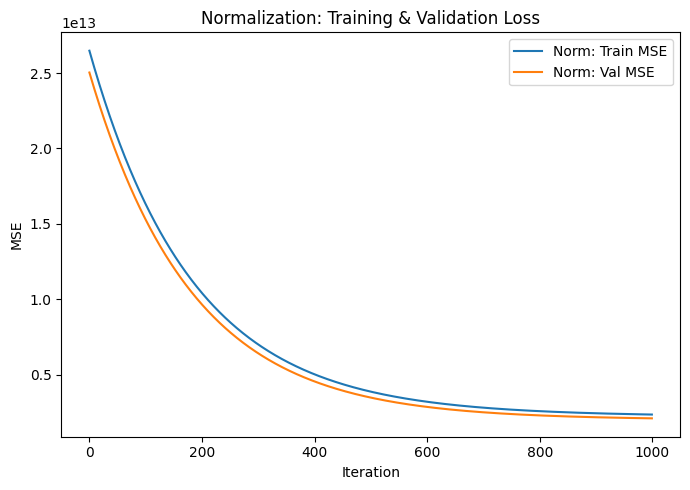

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

# -----------------------------
# Load dataset
# -----------------------------
url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv"
df = pd.read_csv(url)

features = ["area", "bedrooms", "bathrooms", "stories", "parking"]
target   = "price"

X = df[features].values.astype(float)
y = df[target].values.astype(float).reshape(-1, 1)

# -----------------------------
# Fixed Train/Validation split (80/20)
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=100, shuffle=True
)

def add_bias(Z):
    return np.hstack([np.ones((Z.shape[0], 1)), Z])

# -----------------------------
# Gradient Descent (from scratch)
# -----------------------------
def train_gd(X, y, X_val, y_val, lr=1e-6, epochs=1000):
    n, d = X.shape
    theta = np.zeros((d, 1))
    train_losses, val_losses = [], []
    for t in range(epochs):
        y_hat = X @ theta
        grad  = (2.0 / n) * (X.T @ (y_hat - y))
        theta -= lr * grad
        train_losses.append(np.mean((y_hat - y) ** 2))
        val_losses.append(np.mean(((X_val @ theta) - y_val) ** 2))
    return theta, np.array(train_losses), np.array(val_losses)

def evaluate(Xtr, ytr, Xva, yva, theta):
    ytr_hat = Xtr @ theta
    yva_hat = Xva @ theta
    train_mse = np.mean((ytr_hat - ytr)**2)
    val_mse   = np.mean((yva_hat - yva)**2)
    train_r2  = r2_score(ytr, ytr_hat)
    val_r2    = r2_score(yva, yva_hat)
    return train_mse, val_mse, train_r2, val_r2

# ============================================================================
# 1) Baseline (NO SCALING)
# ============================================================================
Xtr_base = add_bias(X_train)
Xva_base = add_bias(X_val)

BASE_LR   = 1e-10    # Reduced step due to unscaled features
EPOCHS    = 1000

theta_base, trL_base, vaL_base = train_gd(Xtr_base, y_train, Xva_base, y_val, lr=BASE_LR, epochs=EPOCHS)
base_train_mse, base_val_mse, base_train_r2, base_val_r2 = evaluate(Xtr_base, y_train, Xva_base, y_val, theta_base)

# ============================================================================
# 2) STANDARDIZATION (inputs only)
# ============================================================================
std_scaler = StandardScaler()
Xtr_std = std_scaler.fit_transform(X_train)
Xva_std = std_scaler.transform(X_val)

Xtr_std_b = add_bias(Xtr_std)
Xva_std_b = add_bias(Xva_std)

STD_LR = 1e-3  # larger, stable step after scaling
theta_std, trL_std, vaL_std = train_gd(Xtr_std_b, y_train, Xva_std_b, y_val, lr=STD_LR, epochs=EPOCHS)
std_train_mse, std_val_mse, std_train_r2, std_val_r2 = evaluate(Xtr_std_b, y_train, Xva_std_b, y_val, theta_std)

# ============================================================================
# 3) NORMALIZATION (Min-Max to [0,1], inputs only)
# ============================================================================
minmax = MinMaxScaler()
Xtr_minmax = minmax.fit_transform(X_train)
Xva_minmax = minmax.transform(X_val)

Xtr_minmax_b = add_bias(Xtr_minmax)
Xva_minmax_b = add_bias(Xva_minmax)

NORM_LR = 1e-3
theta_norm, trL_norm, vaL_norm = train_gd(Xtr_minmax_b, y_train, Xva_minmax_b, y_val, lr=NORM_LR, epochs=EPOCHS)
norm_train_mse, norm_val_mse, norm_train_r2, norm_val_r2 = evaluate(Xtr_minmax_b, y_train, Xva_minmax_b, y_val, theta_norm)

# -----------------------------
# PRINT PARAMETERS (optional)
# -----------------------------
def print_params(label, theta, feature_names):
    print(f"\n=== {label} Model Parameters ===")
    for name, coef in zip(["bias"] + feature_names, theta.flatten()):
        print(f"{name:>10}: {coef:.6f}")

print_params("BASE (no scaling)", theta_base, features)
print_params("STANDARDIZED", theta_std, features)
print_params("NORMALIZED", theta_norm, features)

# -----------------------------
# METRICS COMPARISON TABLE
# -----------------------------
summary = pd.DataFrame({
    "Setting": ["No Scaling (baseline)", "Standardized (inputs)", "Normalized (inputs)"],
    "LR": [BASE_LR, STD_LR, NORM_LR],
    "Epochs": [EPOCHS, EPOCHS, EPOCHS],
    "Train MSE": [base_train_mse, std_train_mse, norm_train_mse],
    "Val   MSE": [base_val_mse,   std_val_mse,   norm_val_mse],
    "Train R²":  [base_train_r2,  std_train_r2,  norm_train_r2],
    "Val   R²":  [base_val_r2,    std_val_r2,    norm_val_r2],
})
print("\n\n=== Comparison (MSE lower is better; R² closer to 1 is better) ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

# -----------------------------
# PLOTS
# -----------------------------
plt.figure(figsize=(7,5))
plt.plot(trL_std, label="Std: Train MSE")
plt.plot(vaL_std, label="Std: Val MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Standardization: Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(trL_norm, label="Norm: Train MSE")
plt.plot(vaL_norm, label="Norm: Val MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Normalization: Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()
